# 第三章 SciPy-数值计算库

SciPy函数库在NumPy库的基础上增加了众多的数学、科学以及工程计算中常用的库函数。本章主要讨论如何用SciPy进行插值处理、信号滤波以及用 C语言加速计算。

本章的学习要点：
1. 最小二乘拟合
2. 函数最小值
3. 非线形方程组求解
4. B-Spline样条曲线
5. 数值积分
6. 解常微分方程组
7. 滤波器设计
8. 用Weave嵌入C语言

## 最小二乘拟合
假设有一组实验数据(x[i], y[i])，我们知道它们之间的函数关系:y = f(x)，通过这些已知信息，需要确定 函数中的一些参数项。例如，如果f是一个线型函数f(x) = k*x+b，那么参数k和b就是我们需要确定的 值。如果将这些参数用 p 表示的话，那么我们就是要找到一组 p 值使得如下公式中的S函数最小:

$ S(p) = \sum_{i=1}^m {[y_i - f(x_i,p)]^2}$

这种算法被称之为最小二乘拟合(Least-square fitting)。

真实参数: [10, 0.34, 0.5235987755982988]
拟合参数 [10.15921887  0.33283126  0.35997419]


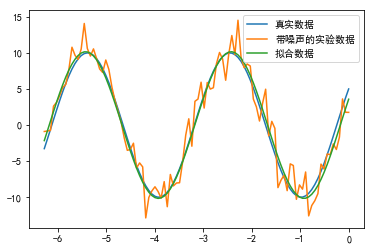

In [3]:
import numpy as np
from scipy.optimize import leastsq 
#scipy中的子函数库optimize已经提供了实现最小二乘拟合算法的函数leastsq
import pylab as pl
#pylab 模块是一款由python提供的可以绘制二维，三维数据的工具模块，其中包括了绘图软件包 matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
def func(x, p):
    """
    数据拟合所用的函数: A*sin(2*pi*k*x + theta) 
    """
    A, k, theta = p
    return A*np.sin(2*np.pi*k*x+theta)

def residuals(p, y, x):
    """
    实验数据x, y和拟合函数之间的差，p为拟合需要找到的系数 
    """
    return y - func(x, p)

x = np.linspace(0, -2*np.pi, 100) #linspace()创建等差数列
A, k, theta = 10, 0.34, np.pi/6 # 真实数据的函数参数
y0 = func(x, [A, k, theta]) # 真实数据
y1 = y0 + 2 * np.random.randn(len(x)) # 加入噪声之后的实验数据

p0 = [7, 0.2, 0] # 第一次猜测的函数拟合参数

# 调用leastsq进行数据拟合
# residuals为计算误差的函数
# p0为拟合参数的初始值
# args为需要拟合的实验数据
plsq = leastsq(residuals, p0, args=(y1, x))

print(u"真实参数:", [A, k, theta])
print(u"拟合参数", plsq[0]) # 实验数据拟合后的参数

pl.plot(x, y0, label=u"真实数据")
pl.plot(x, y1, label=u"带噪声的实验数据") 
pl.plot(x, func(x, plsq[0]), label=u"拟合数据") 
pl.legend()
pl.show()

![调用leastsq函数对噪声正弦波数据进行曲线拟合](调用leastsq函数对噪声正弦波数据进行曲线拟合.png)

书上的图

## 函数最小值

optimize库提供了几个求函数最小值的算法:fmin, fmin_powell, fmin_cg, fmin_bfgs。下面的程序 通过求解卷积的逆运算演示fmin的功能。

对于一个离散的线性时不变系统h, 如果它的输入是x，那么其输出y可以用x和h的卷积表示:

y=x∗h

现在的问题是如果已知系统的输入x和输出y，如何计算系统的传递函数h;或者如果已知系统的传递函 数h和系统的输出y，如何计算系统的输入x。这种运算被称为反卷积运算，是十分困难的，特别是在实 际的运用中，测量系统的输出总是存在误差的。

In [2]:
# -*- coding: utf-8 -*-
# 本程序用各种fmin函数求卷积的逆运算
import scipy.optimize as opt 
import numpy as np

def test_fmin_convolve(fminfunc, x, h, y, yn, x0):
    """
    x (*) h = y, (*)表示卷积 yn为在y的基础上添加一些干扰噪声的结果 x0为求解x的初始值
    """
    def convolve_func(h):
        """
        计算 yn - x (*) h 的power fmin将通过计算使得此power最小
        """
        return np.sum((yn - np.convolve(x, h))**2)
    # 调用fmin函数，以x0为初始值
    h0 = fminfunc(convolve_func, x0)
    print fminfunc.__name__
    print "---------------------"
    # 输出 x (*) h0 和 y 之间的相对误差
    print "error of y:", np.sum((np.convolve(x, h0)-y)**2)/np.sum(y**2) # 输出 h0 和 h 之间的相对误差
    print "error of h:", np.sum((h0-h)**2)/np.sum(h**2)
    print

def test_n(m, n, nscale):
    """
    随机产生x, h, y, yn, x0等数列，调用各种fmin函数求解b m为x的长度, n为h的长度, nscale为干扰的强度
    """
    x = np.random.rand(m)
    h = np.random.rand(n)
    y = np.convolve(x, h)
    #numpy函数中的卷积函数库 ，x和h分别为一个一位数组，百度一下
    yn = y + np.random.rand(len(y)) * nscale
    x0 = np.random.rand(n)

    test_fmin_convolve(opt.fmin, x, h, y, yn, x0)
    test_fmin_convolve(opt.fmin_powell, x, h, y, yn, x0)
    test_fmin_convolve(opt.fmin_cg, x, h, y, yn, x0)
    test_fmin_convolve(opt.fmin_bfgs, x, h, y, yn, x0)

if __name__ == "__main__":
    test_n(200, 20, 0.1)

fmin
---------------------
error of y: 0.0009018395557652177
error of h: 0.04191043749579505

fmin_powell
---------------------
error of y: 8.631423007539054e-05
error of h: 0.0001553558493156767

Optimization terminated successfully.
         Current function value: 0.222078
         Iterations: 25
         Function evaluations: 1144
         Gradient evaluations: 52
fmin_cg
---------------------
error of y: 8.655102957149942e-05
error of h: 0.00015407267927919103

Optimization terminated successfully.
         Current function value: 0.222078
         Iterations: 30
         Function evaluations: 924
         Gradient evaluations: 42
fmin_bfgs
---------------------
error of y: 8.655096889616256e-05
error of h: 0.00015407246886933284



## 非线性方程组求解

optimize库中的fsolve函数可以用来对非线性方程组进行求解：
fsolve(func, x0)

func(x)是计算方程组误差的函数，它的参数x是一个矢量，表示方程组的各个未知数的一组可能解， func返回将x代入方程组之后得到的误差;x0为未知数矢量的初始值。如果要对如下方程组进行求解的话:

• f1(u1,u2,u3) = 0 

• f2(u1,u2,u3) = 0 

• f3(u1,u2,u3) = 0

那么func可以如下定义:

def func(x):

    u1,u2,u3 = x
    return [f1(u1,u2,u3), f2(u1,u2,u3), f3(u1,u2,u3)]

In [3]:
from scipy.optimize import fsolve 
from math import sin,cos
def f(x):
    x0 = float(x[0])
    x1 = float(x[1])
    x2 = float(x[2])
    return [
        5*x1+3,
        4*x0*x0 - 2*sin(x1*x2),
        x1*x2 - 1.5
    ]
result = fsolve(f, [1,1,1])
print result
print f(result)

[-0.70622057 -0.6        -2.5       ]
[0.0, -9.126033262418787e-14, 5.329070518200751e-15]


In [4]:
# -*- coding: utf-8 -*-

from scipy.optimize import fsolve 
from math import sin,cos

def f(x):
    x0 = float(x[0])
    x1 = float(x[1])
    x2 = float(x[2])
    return [
        5*x1+3,
        4*x0*x0 - 2*sin(x1*x2),
        x1*x2 - 1.5
    ]

def j(x):
    x0 = float(x[0])
    x1 = float(x[1])
    x2 = float(x[2])
    return [
        [0, 5, 0],
        [8*x0, -2*x2*cos(x1*x2), -2*x1*cos(x1*x2)],
        [0, x2, x1]
    ]

result = fsolve(f, [1,1,1], fprime=j)
print result
print f(result)

[-0.70622057 -0.6        -2.5       ]
[0.0, -9.126033262418787e-14, 5.329070518200751e-15]


## B-Spline样条曲线

In [6]:
# -*- coding: utf-8 -*-

#下面是使用直线和B-Spline对正弦波上的点进 行插值的例子。

import numpy as np
import pylab as pl
from scipy import interpolate
x = np.linspace(0, 2*np.pi+np.pi/4, 10)
y = np.sin(x)
x_new = np.linspace(0, 2*np.pi+np.pi/4, 100)
f_linear = interpolate.interp1d(x, y) #一维数据的插值运算，有一个kind参数是插值类型

tck = interpolate.splrep(x, y) #样条插值，计算欲插值曲线的样条系数
y_bspline = interpolate.splev(x_new, tck) #计算样条插值结果

pl.plot(x, y, "o", label=u"原始数据") 
pl.plot(x_new, f_linear(x_new), label=u"线性插值") 
pl.plot(x_new, y_bspline, label=u"B-spline插值") 
pl.legend()
pl.show()

#在这段程序中，通过interp1d函数直接得到一个新的线性插值函数。
#而B-Spline插值运算需要先使用 splrep函数计算出B-Spline曲线的参数，
#然后将参数传递给splev函数计算出各个取样点的插值结果。

<Figure size 640x480 with 1 Axes>

![使用interpolate库对正弦波数据进行线性插值和B-Spline插值](使用interpolate库对正弦波数据进行线性插值和B-Spline插值.png)

书上的图

## 数值积分

数值积分是对定积分的数值求解

下面让我们来考虑一 下如何计算半径为1的半圆的面积，根据圆的面积公式，其面积应该等于PI/2。

In [7]:
# 单位半圆曲线可以用下面的函数表示:
def half_circle(x):
    return (1-x**2)**0.5

In [8]:
N = 10000
x = np.linspace(-1, 1, N)
dx = 2.0/N
y = half_circle(x)
dx * np.sum(y[:-1] + y[1:]) # 面积的两倍

3.1412751679989044

In [9]:
import numpy as np
np.trapz(y, x) * 2 # 面积的两倍
#进行数值积分

3.1415893269315975

In [10]:
from scipy import integrate
pi_half, err = integrate.quad(half_circle, -1, 1)
#调用scipy.integrate库中的quad函数的话，将会得到非常精确的结果
pi_half*2

3.1415926535897967

integrate库提供了dblquad函数 进行二重定积分，tplquad函数进行三重定积分。
下面以计算单位半球体积为例说明dblquad函数的用法。
单位半球上的点(x,y,z)符合如下方程:

$x^2 + y^2 + z^2 = 1$

In [11]:
#因此可以如下定义通过(x,y)坐标计算球面上点的z值的函数:
def half_sphere(x, y):
    return (1-x**2-y**2)**0.5

In [12]:
integrate.dblquad(half_sphere, -1, 1, #X轴坐标从-1到1进 行积分，而Y轴从 -half_circle(x) 到 half_circle(x) 进行积分
    lambda x:-half_circle(x),
    lambda x:half_circle(x))
(2.0943951023931988, 2.3252456653390915e-14)
np.pi*4/3/2 # 通过球体体积公式计算的半球体积

2.0943951023931953

lambda举例：

一般的函数是这样:

def f(x):
    
    return x+1
这样使用 print f(4)

用lambda的话，写成这样:

g = lambda x : x+1
这样使用 print g(4)

dblquad函数的调用方式为:

    dblquad(func2d, a, b, gfun, hfun)

## 解常微分方程组
scipy.integrate库提供了数值积分和常微分方程组求解算法odeint。
下面让我们来看看如何用odeint 计算洛仑兹吸引子的轨迹。洛仑兹吸引子由下面的三个微分方程定义:

$\frac{dx}{dt} = \delta(y - x)$

$\frac{dy}{dt} = x(\rho - z) - y$

$\frac{dz}{dt} = xy - \beta z$

这三个方程定义了三维空间中各个坐标点上的速度矢量。从某个坐标开始沿着速度矢量进行积分，就 可以计算出无质量点在此空间中的运动轨迹。其中 σ, ρ, β 为三个常数，不同的参数可以计算出不同的 运动轨迹: x(t), y(t), z(t)。 当参数为某些值时，轨迹出现馄饨现象:即微小的初值差别也会显著地影 响运动轨迹。

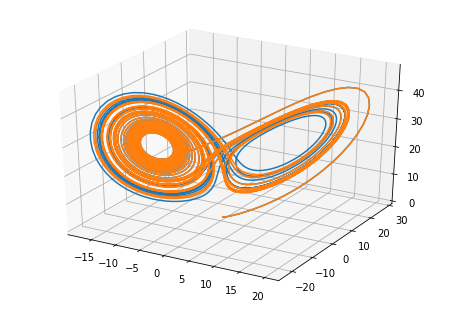

In [13]:
# 下面是洛仑兹吸引子的轨迹计算和绘制程序:
# -*- coding: utf-8 -*-
from scipy.integrate import odeint 
import numpy as np
def lorenz(w, t, p, r, b):
    # 给出位置矢量w，和三个参数p, r, b计算出
    # dx/dt, dy/dt, dz/dt的值
    x, y, z = w
    # 直接与lorenz的计算公式对应
    return np.array([p*(y-x), x*(r-z)-y, x*y-b*z])
t = np.arange(0, 30, 0.01) # 创建时间点
# 调用ode对lorenz进行求解, 用两个不同的初始值
track1 = odeint(lorenz, (0.0, 1.00, 0.0), t, args=(10.0, 28.0, 3.0)) 
track2 = odeint(lorenz, (0.0, 1.01, 0.0), t, args=(10.0, 28.0, 3.0))
# 绘图

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = Axes3D(fig)
ax.plot(track1[:,0], track1[:,1], track1[:,2])
ax.plot(track2[:,0], track2[:,1], track2[:,2])
plt.show()

我们看到即使初始值只相差0.01，两条运动轨迹也是完全不同的。

在程序中先定义一个lorenz函数，它的任务是计算出某个位置的各个方向的微分值，这个计算直接根 据洛仑兹吸引子的公式得出。然后调用odeint，对微分方程求解，odeint有许多参数，这里用到的四 个参数分别为:

1. lorenz， 它是计算某个位移上的各个方向的速度(位移的微分)
2. (0.0, 1.0, 0.0)，位移初始值。计算常微分方程所需的各个变量的初始值
3. t， 表示时间的数组，odeint对于此数组中的每个时间点进行求解，得出所有时间点的位置 
4. args， 这些参数直接传递给lorenz函数，因此它们都是常量

## 滤波器设计

scipy.signal库提供了许多信号处理方面的函数。

In [14]:
#假设如下导入signal库:
import scipy.signal as signal

In [15]:
b, a = signal.iirdesign([0.2, 0.5], [0.1, 0.6], 2, 40)
#这个滤波器的通带为0.2*f0到0.5*f0，阻带为小于0.1*f0和大于0.6*f0，其中f0为1/2的信号取样频率
#iirdesgin返回的两个数组b和a， 它们分别是IIR滤波器的分子和分母部分的系数。其中a[0]恒等于1。

In [16]:
w, h = signal.freqz(b, a)

In [17]:
power = 20*np.log10(np.clip(np.abs(h), 1e-8, 1e100))

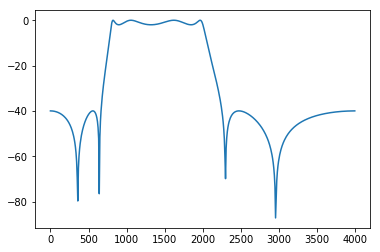

In [18]:
pl.plot(w/np.pi*4000, power)

In [19]:
t = np.arange(0, 2, 1/8000.0)

In [20]:
sweep = signal.chirp(t, f0=0, t1 = 2, f1=4000.0)

In [21]:
out = signal.lfilter(b, a, sweep)

lfilter内部通过如下算式计算IIR滤波器的输出: 

通过如下算式可以计算输入为x时的滤波器的输出，其中数组x代表输入信号，y代表输出信号:
$y[n] = b[0]x[n] + b[1]x[n − 1] + · · · + b[P ]x[n − P ] −a[1]y[n−1]−a[2]y[n−2]−···−a[Q]y[n−Q]$

In [22]:
out = 20*np.log10(np.abs(out)) #先将输出波形数据转换为能量值

In [23]:
index = np.where(np.logical_and(out[1:-1] > out[:-2], out[1:-1] > out[2:]))[0] + 1
#为了计算包络，找到所有能量大于前后两个取样点(局部最大点)的下标

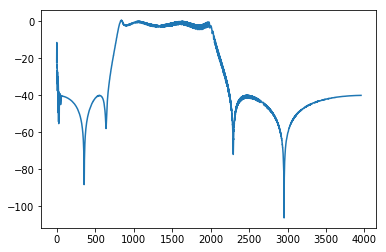

In [24]:
pl.plot(t[index]/2.0*4000, out[index] )
#最后将时间转换为对应的频率，绘制所有局部最大点的能量值

## 用Weave嵌入C语言

Python作为动态语言其功能虽然强大，但是在数值计算方面有一个最大的缺点:速度不够快。在 Python级别的循环和计算的速度只有C语言程序的百分之一。因此才有了NumPy, SciPy这样的函数 库，将高度优化的C、Fortran的函数库进行包装，以供Python程序调用。如果这些高度优化的函数 库无法实现我们的算法，必须从头开始写循环、计算的话，那么用Python来做显然是不合适的。因此 SciPy提供了快速调用C++语言程序的方法-- Weave。

In [28]:
#下面是对NumPy的数组求和的例子:

# -*- coding: utf-8 -*-
#import scipy.weave as weave   weave现在是一个单独的库
import weave #pip install weave可以安装, conda install weave安装不了
import numpy as np
import time
def my_sum(a):
    n=int(len(a))
    code="""
    int i;
    double counter; 
    counter =0; 
    for(i=0;i<n;i++){
        counter=counter+a(i);
    }
    return_val=counter; 
    """

    err=weave.inline(
        code,['a','n'],
        type_converters=weave.converters.blitz,
        #converters.blitz是 一个类型转换器，将numpy的数组类型转换为C++的blitz类
        compiler="gcc"
    )
    return err

a = np.arange(0, 10000000, 1.0)
# 先调用一次my_sum，weave会自动对C语言进行编译，此后直接运行编译之后的代码 
my_sum(a)

start = time.clock()
for i in xrange(100):
    my_sum(a) # 直接运行编译之后的代码
print "my_sum:", (time.clock() - start) / 100.0

start = time.clock()

for i in xrange(100):
    np.sum( a ) # numpy中的sum，其实现也是C语言级别
print "np.sum:", (time.clock() - start) / 100.0

start = time.clock()
print sum(a) # Python内部函数sum通过数组a的迭代接口访问其每个元素，因此速度很慢 
print "sum:", time.clock() - start

creating /var/folders/p_/4mh0n8nj1k5cx7t8lrxf9kv00000gn/T/weave-sunrongcheng-qrvMUc/python27_intermediate/compiler_b7897a7697fd8daa85a4c0dccbcf3fa2
In file included from /Users/sunrongcheng/.cache/weave/python27_compiled/sc_5c71a1f3cd8540af7ece43d4d76263da0.cpp:11:
In file included from /Users/sunrongcheng/anaconda2/lib/python2.7/site-packages/weave/blitz/blitz/array.h:26:
In file included from /Users/sunrongcheng/anaconda2/lib/python2.7/site-packages/weave/blitz/blitz/array-impl.h:37:
/Users/sunrongcheng/anaconda2/lib/python2.7/site-packages/weave/blitz/blitz/range.h:120:34: warning: '&&' within '||' [-Wlogical-op-parentheses]
        return ((first_ < last_) && (stride_ == 1) || (first_ == last_));
                ~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~ ~~
/Users/sunrongcheng/anaconda2/lib/python2.7/site-packages/weave/blitz/blitz/range.h:120:34: note: place parentheses around the '&&' expression to silence this warning
        return ((first_ < last_) && (stride_ == 1) || (first_ == last

# 第四章 SymPy-符号运算好帮手
SymPy是Python的数学符号计算库，用它可以进行数学公式的符号推导。

本章的学习要点：
1. 封面上的经典公式
2. 球体体积

In [29]:
from sympy import *

## 封面上的经典公式
$e^{iπ} + 1 = 0$

欧拉恒等式，其中e是自然指数的底，i是虚数单位， π 是圆周率。

In [30]:
E**(I*pi)+1

0

欧拉恒等式可以下面的公式进行计算

$e^{ix} =cosx+isinx$

In [31]:
#在SymPy中，数学符号是Symbol类的对象，因 此必须先创建之后才能使用
x = Symbol('x')

In [32]:
expand( E**(I*x) ) #expand函数可以将公式展开

exp(I*x)

这里的exp是sympy.exp,它 是一个类，用来表述自然指数函数。

In [33]:
expand(exp(I*x), complex=True)
#expand函数有关键字参数complex，当它为True时，expand将把公式分为实数和虚数两个部分

I*exp(-im(x))*sin(re(x)) + exp(-im(x))*cos(re(x))

re表示取实数部分，im表示取虚 数部分

In [34]:
x = Symbol("x", real=True)
expand(exp(I*x), complex=True)

I*sin(x) + cos(x)

In [35]:
tmp = series(exp(I*x), x, 0, 10)
#用泰勒多项式展开
pprint(tmp)
#series是泰勒展开函数，pprint将公式用更好看的格式打印出来。

           2      3    4      5     6      7      8        9          
          x    ⅈ⋅x    x    ⅈ⋅x     x    ⅈ⋅x      x      ⅈ⋅x      ⎛ 10⎞
1 + ⅈ⋅x - ── - ──── + ── + ──── - ─── - ──── + ───── + ────── + O⎝x  ⎠
          2     6     24   120    720   5040   40320   362880         


In [36]:
pprint(re(tmp))
#获得tmp的实部

   8      6    4    2                 
  x      x    x    x      ⎛ ⎛ 10⎞⎞    
───── - ─── + ── - ── + re⎝O⎝x  ⎠⎠ + 1
40320   720   24   2                  


In [37]:
pprint( series( cos(x), x, 0, 10) )
#sin(x)的泰勒展开式

     2    4     6      8          
    x    x     x      x      ⎛ 10⎞
1 - ── + ── - ─── + ───── + O⎝x  ⎠
    2    24   720   40320         


In [38]:
pprint(im(tmp))
#获得tmp的虚部

   9       7      5    3                 
  x       x      x    x          ⎛ ⎛ 10⎞⎞
────── - ──── + ─── - ── + x + im⎝O⎝x  ⎠⎠
362880   5040   120   6                  


In [39]:
pprint(series(sin(x), x, 0, 10))
#sin(x)的泰勒展开式

     3     5     7       9           
    x     x     x       x       ⎛ 10⎞
x - ── + ─── - ──── + ────── + O⎝x  ⎠
    6    120   5040   362880         


## 球体体积
SymPy的符号积分函数 integrate则可以帮助我们进行符号积分。

In [40]:
#integrate可以进行不定积分:
integrate(x*sin(x), x)

-x*cos(x) + sin(x)

In [41]:
#指定x的取值范围的话，integrate则进行定积分运算:
integrate(x*sin(x), (x, 0, 2*pi))

-2*pi

假设圆形的半径为r，则圆上任意一点的Y 坐标函数为:

$y(x) = 􏰅\sqrt{r^2 − x^2}$

In [42]:
#可以直接对上述函数在-r到r区间上进行积分得到半圆面积
x, y, r = symbols('x,y,r')
2 * integrate(sqrt(r*r-x**2), (x, -r, r))

2*Integral(sqrt(r**2 - x**2), (x, -r, r))

integrate函数没有计算出结果，而是直接返回了我们输入的算式。这是因为SymPy不知道r是 大于0的

In [43]:
r = symbols('r', positive=True)
circle_area = 2 * integrate(sqrt(r**2-x**2), (x, -r, r))
circle_area

pi*r**2

对此面积公式进行定积分，就可以得到球体的体积，但是随着X轴坐标的变化，对应的切面的的 半径会发生变化，现在假设X轴的坐标为x，球体的半径为r，则x处的切面的半径为可以使用前面的公 式y(x)计算出。

In [44]:
#因此我们需要对circle_area中的变量r进行替代:
circle_area = circle_area.subs(r, sqrt(r**2-x**2))
circle_area

pi*(r**2 - x**2)

用subs进行算式替换
subs函数可以将算式中的符号进行替换，它有3种调用方式: 
    
    • expression.subs(x, y) : 将算式中的x替换成y
    • expression.subs({x:y,u:v}) : 使用字典进行多次替换
    • expression.subs([(x,y),(u,v)]) : 使用列表进行多次替换
    
    expression.sub([(x,y),(y,x)])
    
请注意多次替换是顺序执行的，因此:
并不能对两个符号x,y进行交换。

In [46]:
#然后对circle_area中的变量x在区间-r到r上进行定积分，得到球体的体积公式:
integrate(circle_area, (x, -r, r))

4*pi*r**3/3